In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import math
import time
import matplotlib.gridspec as gridspec

from astropy.io import ascii
from itertools import cycle
from itertools import permutations
from scipy.stats import skew

%matplotlib inline

# Plotting code

In [57]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [75]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, 
             linkSystems=False, sysIdxs=None,
             sizes=75, legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata)#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata)#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
        
    if linkSystems is True:
        for i in np.unique(sysIdxs):
            if len(xdata[sysIdxs==i]) > 1:
                if "P" in xlabel:
                    psort = np.argsort(xdata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][psort],ydata[sysIdxs==i][psort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                elif "P" in ylabel:
                    psort = np.argsort(ydata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][psort],ydata[sysIdxs==i][psort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                else:
                    sort = np.argsort(xdata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][sort],ydata[sysIdxs==i][sort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                
            #else:
            #    ax.plot(xdata[sysIdxs==i],ydata[sysIdxs==i],lw=0.5,marker='o',ms=np.sqrt(sizes),mec='k',mfc='None',ls='None',color='k',alpha=alpha)
            
    return 

In [76]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    lastEpochCost = float(lastEpoch[2].split(" ")[2])
    return lastEpochCost

In [86]:
def classToPlanet_stable(testSetSystems, testSetResults, trainingSetResults, trainingSetData, nSamples):
    """
    Take a vector of class membership probabilities for a planet, and use that (in combination with 
    information about the class members from the training data) to predict the planet's properties.
    
    """
    nClasses = np.shape(trainingSetResults)[1]
    #print(nClasses)
    trainingSet_bestClass = np.argmax(trainingSetResults, axis=1)
    #print(np.shape(trainingSet_bestClass))
    #print(trainingSet_bestClass)
    #print(trainingSetData)
    
    testSetPredictions = np.zeros((len(testSetResults), nSamples, np.shape(trainingSetData)[1]))
    
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity

        m = len(thisSystem)

        # planet by planet
        for j in range(m):
            thisTestPlanetResults = testSetResults[planetCounter]
            #make this array cumulative
            for k in range(0,nClasses-1):
                thisTestPlanetResults[k+1] = thisTestPlanetResults[k+1] + thisTestPlanetResults[k]

            #print(planetCounter)
            if j == 0:
                Pmin = np.min(trainingSetData[:,1])
            else:
                Pmin = thisSystem[j-1][1]
                
            if j == (m-1):
                Pmax = np.max(trainingSetData[:,1])
            else:
                Pmax = thisSystem[j+1][1]
            
            #draw random planets from the training set that have acceptable periods
            samplePlanets = np.zeros((nSamples,np.shape(trainingSetData)[1]))
            
            for ii in range(nSamples):
                rando = float(np.random.uniform(0.,1.))
            
                for jj in range(nClasses):
                    if (rando <= thisTestPlanetResults[jj]):
                        classToDraw = jj
                        break
                
                #print(classToDraw)
                poolMask = (trainingSet_bestClass == classToDraw) & (trainingSetData[:,1] > Pmin) & (trainingSetData[:,1] < Pmax)
                poolIdxs = np.arange(len(trainingSetData))[poolMask]
                
                if len(poolIdxs) == 0:
                    break
                    
                samplePlanetIdx = np.random.choice(poolIdxs)
                samplePlanets[ii] = trainingSetData[samplePlanetIdx]
            
            testSetPredictions[planetCounter] = samplePlanets
            planetCounter+=1
    
    return testSetPredictions
    

In [87]:
def randomStablePlanet(testSetSystems, testSetResults, trainingSetResults, trainingSetData, nSamples):
    """
    Predict properties of a planet randomly. (Do not allow orbit crossings, assuming circularity.)
    
    """
    randomPredictions = np.zeros((len(testSetResults), nSamples, np.shape(trainingSetData)[1]))
    
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity
        
        m = len(thisSystem)
        
        # planet by planet
        for j in range(0,m):
            if j == 0:
                Pmin = np.min(trainingSetData[:,1])
            else:
                Pmin = thisSystem[j-1][1]
                
            if (j == (m-1)):
                Pmax = np.max(trainingSetData[:,1])
            else:
                Pmax = thisSystem[j+1][1]
            
            #draw random planets from the training set that have acceptable periods
            samplePlanets = np.zeros((nSamples,np.shape(trainingSetData)[1]))
            
            allowedPMask = (trainingSetData[:,1] > Pmin) & (trainingSetData[:,1] < Pmax)
            allowedPIdxs = np.arange(len(trainingSetData))[allowedPMask]
            #print(len(allowedPIdxs))
            if len(allowedPIdxs) == 0:
                break
            
            if nSamples > len(allowedPIdxs):
                print("{0}: not enough stable planets".format(j))
                break
            
            for k in range(nSamples):

                samplePlanetIdx = np.random.choice(allowedPIdxs)

                samplePlanets[k] = trainingSetData[samplePlanetIdx]
            
            randomPredictions[planetCounter] = samplePlanets
            planetCounter+=1
                
    return randomPredictions
    

In [79]:
def fracMSE(X_predicted,X_true):
    mse = ((X_predicted - X_true)/X_true)**2
    return mse

In [80]:
def fracMSE_analytic(testSetSystems, testSetResults, trainingSetResults, trainingSetData, nSamples):
    """
    Make the prediction for test set planet i that analytically minimizes the fractional MSE
    (X_pred - X_true)**2/X_true**2 
    """
    
    nClasses = np.shape(trainingSetResults)[1]
    nFeatures = len(trainingSetData[0])
    
    testSetPredictions = np.zeros((len(testSetResults), np.shape(trainingSetData)[1]))
    print("nPlanets={0}".format(len(testSetPredictions)))
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity

        m = len(thisSystem)

        # planet by planet
        for j in range(0,m):
            print("planet {0}".format(planetCounter))
            # class membership probabilities
            thisTestPlanetResults = testSetResults[planetCounter]
            print("thisTestPlanetResults: {0}".format(thisTestPlanetResults))
            
            num = 0
            denom = 0
            
            # loop over classes
            for k in range(0,nClasses):
                #how many training planets in this class?
                classKmask = (np.argmax(trainingSetResults, axis=1) == k)
                trainingSetPlanets_classK = trainingSetData[classKmask]
                nk = len(trainingSetPlanets_classK)
                print("nk is {0}".format(nk))
                
                num_ = 0
                denom_ = 0
                
                for k_ in range(nk):
                    
                    #all training planets except planet k_
                    setJ = trainingSetPlanets_classK[ np.arange(nk) != k_ ] 
                    n_inner_sum = np.sum(setJ**2, axis=1)

                    n_product = np.product(n_inner_sum) # this is always inf...
                    
                    num_ += n_product * trainingSetPlanets_classK[k_]
                    denom_ += n_product
                
                num += thisTestPlanetResults[k] * (num_)
                denom += thisTestPlanetResults[k] * (denom_)
                            
            testSetPredictions[planetCounter] = num/denom
            planetCounter+=1
    
    return testSetPredictions

In [88]:
def MSE_analytic(testSetSystems, testSetResults, trainingSetResults, trainingSetData):
    """
    Make the prediction for test set planet i that analytically minimizes the MSE
    (X_pred - X_true)**2
    """
    
    nClasses = np.shape(trainingSetResults)[1]
    nFeatures = len(trainingSetData[0])
    
    testSetPredictions = np.zeros((len(testSetResults), np.shape(trainingSetData)[1]))
    #print("nPlanets={0}".format(len(testSetPredictions)))
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity

        m = len(thisSystem)

        # planet by planet
        for j in range(0,m):
            # class membership probabilities
            thisTestPlanetResults = testSetResults[planetCounter]
            
            num = 0
            denom = 0
            
            # loop over classes
            for k in range(0,nClasses):
                #how many training planets in this class?
                classKmask = (np.argmax(trainingSetResults, axis=1) == k)
                trainingSetPlanets_classK = trainingSetData[classKmask]
                nk = len(trainingSetPlanets_classK)
                
                num += thisTestPlanetResults[k] * np.sum(trainingSetPlanets_classK, axis=0)
                denom += thisTestPlanetResults[k] * nk
            
            testSetPredictions[planetCounter] = num/denom
            planetCounter+=1
    
    return testSetPredictions

In [89]:
def MSE_pop_analytic(testSetSystems, testSetResults, trainingSetResults, trainingSetData):
    """
    Make the prediction for test set planet i that analytically minimizes the MSE
    (X_pred - X_true)**2
    """
    
    nClasses = np.shape(trainingSetResults)[1]
    nFeatures = len(trainingSetData[0])
    
    testSetPredictions = np.zeros((len(testSetResults), np.shape(trainingSetData)[1]))
    #print("nPlanets={0}".format(len(testSetPredictions)))
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity

        m = len(thisSystem)

        # planet by planet
        for j in range(0,m):
            # class membership probabilities
            thisTestPlanetResults = testSetResults[planetCounter]
            
            pred = 0
            
            # loop over classes
            for k in range(0,nClasses):
                #how many training planets in this class?
                classKmask = (np.argmax(trainingSetResults, axis=1) == k)
                trainingSetPlanets_classK = trainingSetData[classKmask]
                nk = len(trainingSetPlanets_classK)
                
                if nk > 0:
                    pred += (thisTestPlanetResults[k] * np.sum(trainingSetPlanets_classK, axis=0))/nk
                else:
                    pred += 0
            
            testSetPredictions[planetCounter] = pred
            planetCounter+=1
    
    return testSetPredictions

In [90]:
def bootstrap(nTrials,function,testSetSystems, testSetResults, trainingSetResults, trainingSetData):
    nTestPlanets = len(testSetResults)
    nTrainingPlanets = len(trainingSetResults)
    
    bootstrapped = np.zeros((nTestPlanets, np.shape(trainingSetData)[1], nTrials))
    
    for i in range(nTrials):
        print(i)
        idxs = np.random.choice(np.arange(nTrainingPlanets), size=nTrainingPlanets, replace=True)
        bootstrapped[:,:,i] = function(testSetSystems, testSetResults, trainingSetResults[idxs], trainingSetData[idxs])
    
    #fig = plt.figure(figsize=(8,6))
    #for j in range(nTrials):
    #    plt.hist(bootstrapped[:,-1,j],range=(-0.2,.2),bins=10,alpha=0.1)
    #plt.show()
    return np.percentile(bootstrapped, q=(2.5,50,97.5), axis=2)
    #return np.percentile(bootstrapped, q=(16,50,84), axis=2)

# Loop over different choices of num_classes

In [91]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems.csv")

obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T


In [96]:
# stuff that's true regardless of num_classes
trainingDataFile = "./realPlanets_obs/realKOIs_obsFeatures_70percent.txt"
CVDataFile = "./realPlanets_obs/realKOIs_obsFeatures_30percent.txt"

# constraints based on stability
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")
print(np.shape(constraints))

n_planet_features = 2
n_stellar_features = 2
n_features = n_planet_features + n_stellar_features

# for predictions
n_samples = 100


features = obs_features
mus = np.mean(features,axis=0)
sigmas = np.std(features,axis=0)


# obs
labels = [r'$\log_{10}R_p/R_*$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
scatterlims = [(-2.5,-1.),(-0.75,3),(4000,7000),(3.75,5.25)]

# mod
#labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}a$ [AU]',r'$\log_{10}S\ [S_\oplus]$',r'$\log_{10}R_*\ [R_\odot]$',r'$\log_{10}M_*\ [M_\odot]$'']
#lims = [(-2,2),(-2,2),(-1.,1.),(-1.,1.),(-1.,1.)]
#scatterlims = [(-0.5,1.25),(-0.75,3),(-3,3),(-3,3),(-3,3)]


classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B','#2E8B57','#EE4266','#540D6E','#064F40','#F54D27']


(857, 11)


# Figure out which random seed 0,...,99 and which n_classes 2,...,15 had the optimal cost function.

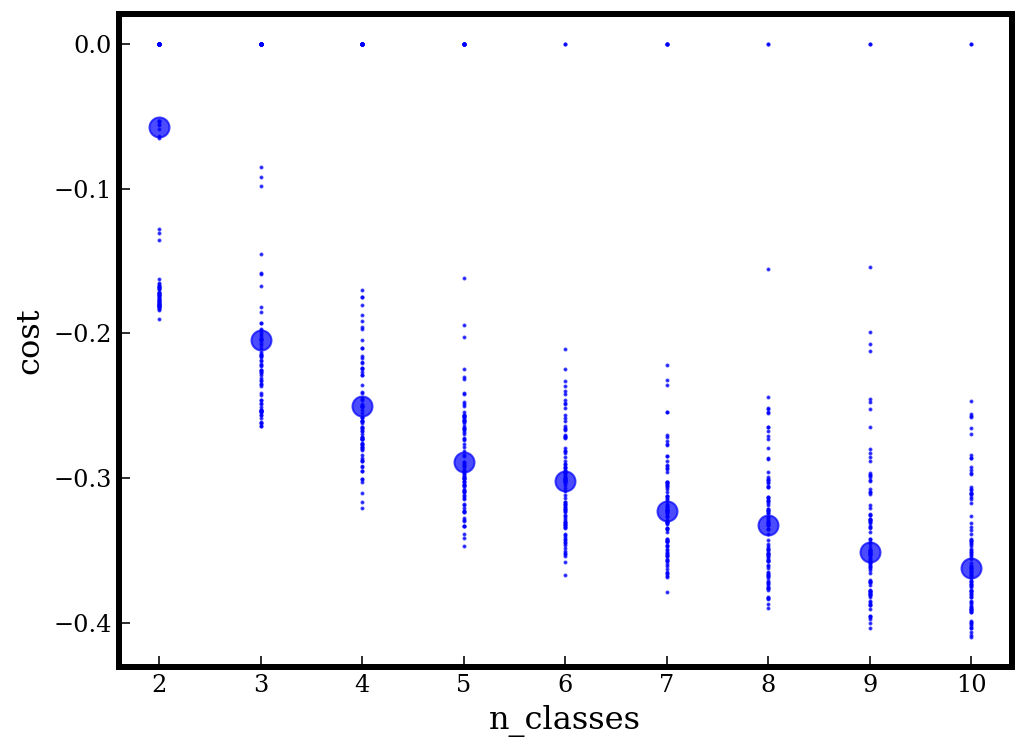

In [93]:
loss_arr = np.zeros((9,100))

for i, nc in enumerate(range(2,11)):
    for j, s in enumerate(range(0,100)):
        resultsFolder = "./realPlanets_obs/{0}classes".format(nc)
        loss_arr[i,j] = getLossFromLogfile("{0}/realKOIs_obsFeatures_{1}classes_seed={2}.log".format(resultsFolder,nc,s))
"""
for i, nc in enumerate(range(2,11)):
    print(np.min(loss_arr[i]))
    fig = plt.figure(figsize=(4,3))
    plt.hist(loss_arr[i],range=(-0.5,0.),color='b',alpha=0.7)
    plt.title("n_classes = {0}".format(nc),fontsize=16)
    plt.show()"""

fig = plt.figure(figsize=(8,6))
for j in range(100):
    plt.plot(np.arange(2,11),loss_arr[:,j],'b.',ls="None",ms=2,alpha=0.7)
plt.plot(np.arange(2,11),np.median(loss_arr,axis=1),'b.',ls="None",ms=20,alpha=0.7)
plt.xlabel("n_classes",fontsize=16)
plt.ylabel("cost",fontsize=16)
plt.show()

In [70]:
print(np.min(loss_arr,axis=1))
print(np.argmin(loss_arr,axis=1))

[-0.19024251 -0.26377191 -0.32074003 -0.34663782 -0.36662194 -0.37854722
 -0.38994153 -0.40364703 -0.40976867]
[96 61 58 87 82 27 60 98  7]


In [52]:
# classification plots for training data first
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)
#classes = np.array((10,))
#seeds = np.array((3,))

for n_idx in np.arange(len(classes)):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_obs/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_obsFeatures_{1}classes.log".format(resultsFolder,n_classes)

    # get training data
    with open(trainingDataFile, "rb") as picklefile:
        trainingSystems = pickle.load(picklefile)

    data = np.zeros((1,n_features+1))

    for i in range(len(trainingSystems)):
        sys = trainingSystems[i]
        for j in range(1,len(sys)):
            row = np.zeros_like(data[0])
            row[:-1] = np.array(sys[j])
            row[-1] = i
            data = np.vstack((data,row))
    data = data[1:]
    #print(data)
    #print(np.shape(data))

    mults = np.zeros_like(data[:,0])
    for i in range(len(data)):
        thisSystemMask = (data[:,-1] == data[i,-1])
        mults[i] = int(len(data[thisSystemMask]))
    
    data = np.hstack((data,np.atleast_2d(mults).T))
    #print(mults)
    #print(len(mults[mults==1]))
    #print(len(mults[mults==2])/2.)
    #print(len(mults[mults==3])/3.)
    #print(len(mults[mults==4])/4.)
    #print(len(mults[mults==5])/5.)
    #print(len(mults[mults==6])/6.)        
    
    losses = np.load("{0}/realKOIs_obsFeatures_70percent_losses_{1}.npy".format(resultsFolder,seed))
    results = np.load("{0}/realKOIs_obsFeatures_70percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    results_fromContext = np.exp(np.load("{0}/realKOIs_obsFeatures_70percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    idxs = np.load("{0}/realKOIs_obsFeatures_70percent_idxs_{1}.npy".format(resultsFolder,seed))

    data = data[idxs]

    bestClass = np.argmax(results,axis=1)
    bestClass_fromContext = np.argmax(results_fromContext,axis=1)

    # do not plot single-planet systems!!
    #bestClass = bestClass[data[:,-1] > 1]
    #bestClass_fromContext = bestClass_fromContext[data[:,-1] > 1]
    #data = data[data[:,-1] > 1]
    
    # TRUTHS and RESULTS
    arrays_ = [bestClass,bestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        data_toplot = data[data[:,-1] == m]
        print(np.shape(data_toplot))
        arrays_ = [bestClass[data[:,-1]==m],bestClass_fromContext[data[:,-1]==m]]
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_features,7*n_features))
            gs = gridspec.GridSpec(n_features, n_features)

            for i in range(n_features):
                for j in range(n_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((data_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((data_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=True,
                                sysIdxs=data_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                legendEntries=np.array(class_legendEntries).astype(int),
                                legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=0.25)

                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(data[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((data_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((data_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)


            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_obsFeatures_70percent_{1}classes_{2}_{3}_mult={4}.png".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="png")
            plt.close()

n_classes is 2
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 3
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 4
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 5
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 6
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 7
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 8
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 9
mult is 1.0
(1446, 6)
mult is 2.0
(564, 6)
mult is 3.0
(267, 6)
mult is 4.0
(112, 6)
mult is 5.0
(70, 6)
n_classes is 10
mult is 1.0
(1446, 6)
mu

In [103]:
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)
print(seeds)

optimalLosses = []
nDisagrees = []
predMSE_rad = []
randomMSE_rad = []
predMSE_per = []
randomMSE_per = []
#predMSE_insol = []
#randomMSE_insol = []
predMSE_teff = []
randomMSE_teff = []
predMSE_logg = []
randomMSE_logg = []
#predMSE_met = []
#randomMSE_met = []

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_obs/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_obsFeatures_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    CVconstraints = np.zeros((1,8))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
    CVdata = CVdata[1:]
    CVconstraints = CVconstraints[1:]
    print(len(CVdata))
    print(np.shape(CVdata))
    print(np.shape(CVconstraints))
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_obsFeatures_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_obsFeatures_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_obsFeatures_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_obsFeatures_30percent_idxs_{1}.npy".format(resultsFolder,seed))

    CVdata = CVdata[CVidxs]
    CVconstraints = CVconstraints[CVidxs]

    optimalLoss = getLossFromLogfile("{0}/realKOIs_obsFeatures_{1}classes_seed={2}.log".format(resultsFolder,n_classes,seed))
    optimalLosses.append(optimalLoss)

    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)

    
    # Do not plot single-planet systems!!
    #CVbestClass_nosingles = CVbestClass[CVdata[:,-1] > 1]
    #CVbestClass_fromContext_nosingles = CVbestClass_fromContext[CVdata[:,-1] > 1]
    #CVdata_nosingles = CVdata[CVdata[:,-1] > 1]
    
    nDisagree = len(np.arange(len(CVbestClass))[CVbestClass != CVbestClass_fromContext])
    nDisagrees.append(nDisagree)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    '''
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        CVdata_toplot = CVdata[CVdata[:,-1] == m]
        arrays_ = [CVbestClass[CVdata[:,-1]==m],CVbestClass_fromContext[CVdata[:,-1]==m]]
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_features,7*n_features))
            gs = gridspec.GridSpec(n_features, n_features)

            for i in range(n_features):
                for j in range(n_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((CVdata_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((CVdata_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=True,
                                sysIdxs=CVdata_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                legendEntries=np.array(class_legendEntries).astype(int),
                                legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=0.25)

                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(CVdata[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)


            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_obsFeatures_30percent_{1}classes_{2}_{3}_mult={4}.png".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="png")
            plt.close()
    
    '''
    # get training data
    trainingIdxs = np.load("{0}/realKOIs_obsFeatures_70percent_idxs_{1}.npy".format(resultsFolder,seed))

    with open(trainingDataFile,"rb") as picklefile:
        trainingSystems = pickle.load(picklefile)

    trainingData = np.zeros((1,n_features))

    for i in range(len(trainingSystems)):
        sys = trainingSystems[i]
        for j in range(1,len(sys)):
            trainingData = np.vstack((trainingData,np.array(sys[j])))

    trainingData = trainingData[1:][trainingIdxs]
    trainingResults = np.load("./{0}/realKOIs_obsFeatures_70percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    print(np.shape(trainingData))
    print(np.shape(trainingResults))
    print(np.shape(CVresults_fromContext))
    #fig = plt.figure(figsize=(8,6))
    #plt.hist(trainingData[:,-1],bins=50,color='b',alpha=0.4)
    #plt.hist(CVdata[:,-1],bins=50,color='r',alpha=0.4)
    #plt.show()
    
    # training-based predictions
    #stablePredictionsMC = classToPlanet_stable(testSetSystems=testSystems, 
    #                                        testSetResults=CVresults_fromContext,
    #                                        trainingSetResults=trainingResults, 
    #                                        trainingSetData=trainingData, 
    #                                        nSamples=n_samples)
    
    
    stablePredictions = MSE_analytic(testSetSystems=testSystems, 
                                            testSetResults=CVresults_fromContext,
                                            trainingSetResults=trainingResults, 
                                            trainingSetData=trainingData)
    #print(np.shape(stablePredictions))
    #np.save("{0}/realKOIs_allFeatures_{1}classes_CV_stablePredictions_{2}.npy".format(resultsFolder,n_classes,seed),stablePredictions)
    
    #stablePredictionsPop = MSE_pop_analytic(testSetSystems=testSystems, 
    #                                        testSetResults=CVresults_fromContext,
    #                                        trainingSetResults=trainingResults, 
    #                                        trainingSetData=trainingData, 
    #                                        nSamples=n_samples)
    
    #stablePredictions = np.load("{0}/realKOIs_allFeatures_{1}classes_CV_stablePredictions_{2}.npy".format(resultsFolder,n_classes,seed))
    
    #bootstrapped training-based predictions
    stablePredictionsBootstrap = bootstrap(nTrials=100,
                                  function=MSE_analytic,
                                  testSetSystems=testSystems, 
                                  testSetResults=CVresults_fromContext, 
                                  trainingSetResults=trainingResults, 
                                  trainingSetData=trainingData)
    print(np.shape(stablePredictions)) #3, nPlanets, nFeatures
    
    print(np.shape(stablePredictionsBootstrap))
    for i in range(n_features):
        stablePredictionsBootstrap[:,:,i] = (stablePredictionsBootstrap[:,:,i]*sigmas[i])+mus[i]
        
    stablePredictions_med = stablePredictionsBootstrap[1,:,:]
    stablePredictions_lower = stablePredictionsBootstrap[1,:,:] - stablePredictionsBootstrap[0,:,:]
    stablePredictions_upper = stablePredictionsBootstrap[2,:,:] - stablePredictionsBootstrap[1,:,:]
    stablePredictions_unc = np.vstack((stablePredictions_lower.T,stablePredictions_upper.T)).T    

    #fig,axes = plt.subplots(1,2,figsize=(16,6))
    #axes[0].hist(stablePredictions_lower[:,0],color='b',alpha=0.5)
    #axes[1].hist(stablePredictions_upper[:,0],color='b',alpha=0.5)
    #plt.show()
    
    # naive predictions
    randomPredictions = randomStablePlanet(testSetSystems=testSystems, 
                                            testSetResults=CVresults_fromContext,
                                            trainingSetResults=trainingResults, 
                                            trainingSetData=trainingData, 
                                            nSamples=n_samples)
        
    # plot training-based predictions
    #markers=['.','v','X','1','s','x','^','2','D','o']
    markers=['.']
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
    
    for m in np.sort(np.unique(mults)):
        fig,axes = plt.subplots(1,n_features,figsize = (n_features*5,4))
    
        
        # Rp/R* constraints
        xs = ((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m]
        cs = CVconstraints[CVdata[:,-1] == m]
        
        #for cc in range(len(cs)):
        #    axes[0].axvline(x=xs[cc],ymin=cs[cc,5]-cs[cc,7],ymax=cs[cc,5]+cs[cc,6],color='b',lw=1)
            
        # period
        xs = ((CVdata[:,1]*sigmas[1])+mus[1])[CVdata[:,-1] == m]
        cs = CVconstraints[CVdata[:,-1] == m]
        
        for cc in range(len(cs)):
            axes[1].axvline(x=xs[cc],ymin=np.log10(cs[cc,2]),ymax=np.log10(cs[cc,3]),color='b',lw=1)
            
        for i in range(n_features):    
            axes[i].errorbar(x=((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                             y=stablePredictions_med[:,i][CVdata[:,-1] == m],
                             yerr=stablePredictions_unc[:,i][CVdata[:,-1] == m],
                             color='r',marker='.',ms=10,mec="k",capsize=0,elinewidth=1,ls="None",alpha=0.2,zorder=2)

            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                         ((randomPredictions[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                         color='k',marker='.',ms=5,mec="None",ls="None",alpha=0.1,zorder=1)

            axes[i].set_xlabel("{0}, true".format(labels[i]))
            axes[i].set_ylabel("{0}, predicted from context".format(labels[i]))
            axes[i].set_xlim(scatterlims[i])
            axes[i].set_ylim(scatterlims[i])

            x_ = np.linspace(scatterlims[i][0],scatterlims[i][1],2)
            axes[i].plot(x_,x_,'k:',lw=1)
            #axes[i].legend(loc='best',frameon='False')
        plt.subplots_adjust(wspace=0.5)
        #plt.show()
        axes[0].set_title("n_classes = {0}".format(n_classes))
        plt.savefig("./{0}/realKOIs_obsFeatures_30percent_{1}classes_CV_stablePredictions_{2}_mult={3}.png".format(resultsFolder,n_classes,seed,m))
        plt.close()
    
    
        # histograms of (X_predicted - X_true)/X_true
        fig,axes = plt.subplots(1,n_features,figsize = (n_features*5,4))

        for i in range(n_features):
            phys_truth = ((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]

            frac_err_pred = np.zeros_like(phys_truth)
            frac_err_random = np.zeros_like(phys_truth)

            phys_pred = (stablePredictions_med[:,i])[CVdata[:,-1] == m]
            frac_err_pred = (phys_pred - phys_truth)/phys_truth

            #phys_pred_pop = (stablePredictionsPop_med[:,i]*sigmas[i])+mus[i]
            #frac_err_pred_pop = (phys_pred_pop - phys_truth)/phys_truth

            for j in range(1):
                phys_random = ((randomPredictions[:,j,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
                frac_err_random_j = (phys_random - phys_truth)/phys_truth
                frac_err_random = np.vstack((frac_err_random,frac_err_random_j))

            frac_err_random = frac_err_random[1:]
            frac_err_random = np.ravel(frac_err_random)

            MSE_pred = np.sum(frac_err_pred[np.isfinite(frac_err_pred)]**2)
            #MSE_pred_pop = np.sum(frac_err_pred_pop[np.isfinite(frac_err_pred_pop)]**2)
            MSE_random = np.sum(frac_err_random[np.isfinite(frac_err_random)]**2)

            skew_pred = skew(frac_err_pred)
            #skew_pred_pop = skew(frac_err_pred_pop)
            skew_random = skew(frac_err_random)

            axes[i].hist(frac_err_pred,range=lims[i],bins=30,facecolor="r",edgecolor="r",alpha=0.2,label="network-predicted\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_pred,skew_pred))
            #axes[i].hist(frac_err_pred_pop,range=lims[i],bins=30,facecolor="g",edgecolor="b",alpha=0.2,label="network-predicted\npop-based MSE={0:.1e},\nskewness={1:.1f}".format(MSE_pred_pop,skew_pred_pop))

            axes[i].hist(frac_err_random,range=lims[i],bins=30,facecolor="None",edgecolor="k",lw=1.5,alpha=0.7,label="random\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_random,skew_random))
            axes[i].axvline(x=0,color='k',ls=':',lw=1)
            axes[i].set_xlabel("{0}, (predicted-true)/true".format(labels[i]))
            #axes[i].set_xlabel("{0}, (predicted-true)".format(labels[i]))
            axes[i].set_ylabel("count".format(labels[i]))
            axes[i].legend(loc="upper right",frameon=False)
        axes[0].set_title("n_classes = {0}".format(n_classes))
        plt.subplots_adjust(wspace=0.5)
        #plt.show()
        plt.savefig("./{0}/realKOIs_obsFeatures_30percent_{1}classes_CV_stablePredictions_hist_{2}_mult={3}.png".format(resultsFolder,n_classes,seed,m))
        plt.close()

        
    for i in range(n_features):
        if i == 0:
            predMSE_rad.append(MSE_pred)
            randomMSE_rad.append(MSE_random)
        elif i==1:
            predMSE_per.append(MSE_pred)
            randomMSE_per.append(MSE_random)
        elif i==2:
            #predMSE_insol.append(MSE_pred)
            #randomMSE_insol.append(MSE_random)
            #elif i==3:
            predMSE_teff.append(MSE_pred)
            randomMSE_teff.append(MSE_random)
        elif i==3:
            predMSE_logg.append(MSE_pred)
            randomMSE_logg.append(MSE_random)
        #elif i==5:
        #    predMSE_met.append(MSE_pred)
        #    randomMSE_met.append(MSE_random)
    
    
    

optimalLosses = np.array(optimalLosses)
nDisagrees = np.array(nDisagrees)

predMSE_rad = np.array(predMSE_rad)
randomMSE_rad = np.array(randomMSE_rad)
predMSE_per = np.array(predMSE_per)
randomMSE_per = np.array(randomMSE_per)
#predMSE_insol = np.array(predMSE_insol)
#randomMSE_insol = np.array(randomMSE_insol)
predMSE_teff = np.array(predMSE_teff)
randomMSE_teff = np.array(randomMSE_teff)
predMSE_logg = np.array(predMSE_logg)
randomMSE_logg = np.array(randomMSE_logg)
#predMSE_met = np.array(predMSE_met)
#randomMSE_met = np.array(randomMSE_met)

[96 61 58 87 82 27 60 98  7]
n_classes is 2
1053
(1053, 5)
(1053, 8)
(2459, 4)
(2459, 2)
(1053, 2)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(1053, 4)
(3, 1053, 4)


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:267: RuntimeWarning: divide by zero encountered in log10


n_classes is 3
1053
(1053, 5)
(1053, 8)
(2459, 4)
(2459, 3)
(1053, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(1053, 4)
(3, 1053, 4)
n_classes is 4
1053
(1053, 5)
(1053, 8)
(2459, 4)
(2459, 4)
(1053, 4)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


KeyboardInterrupt: 

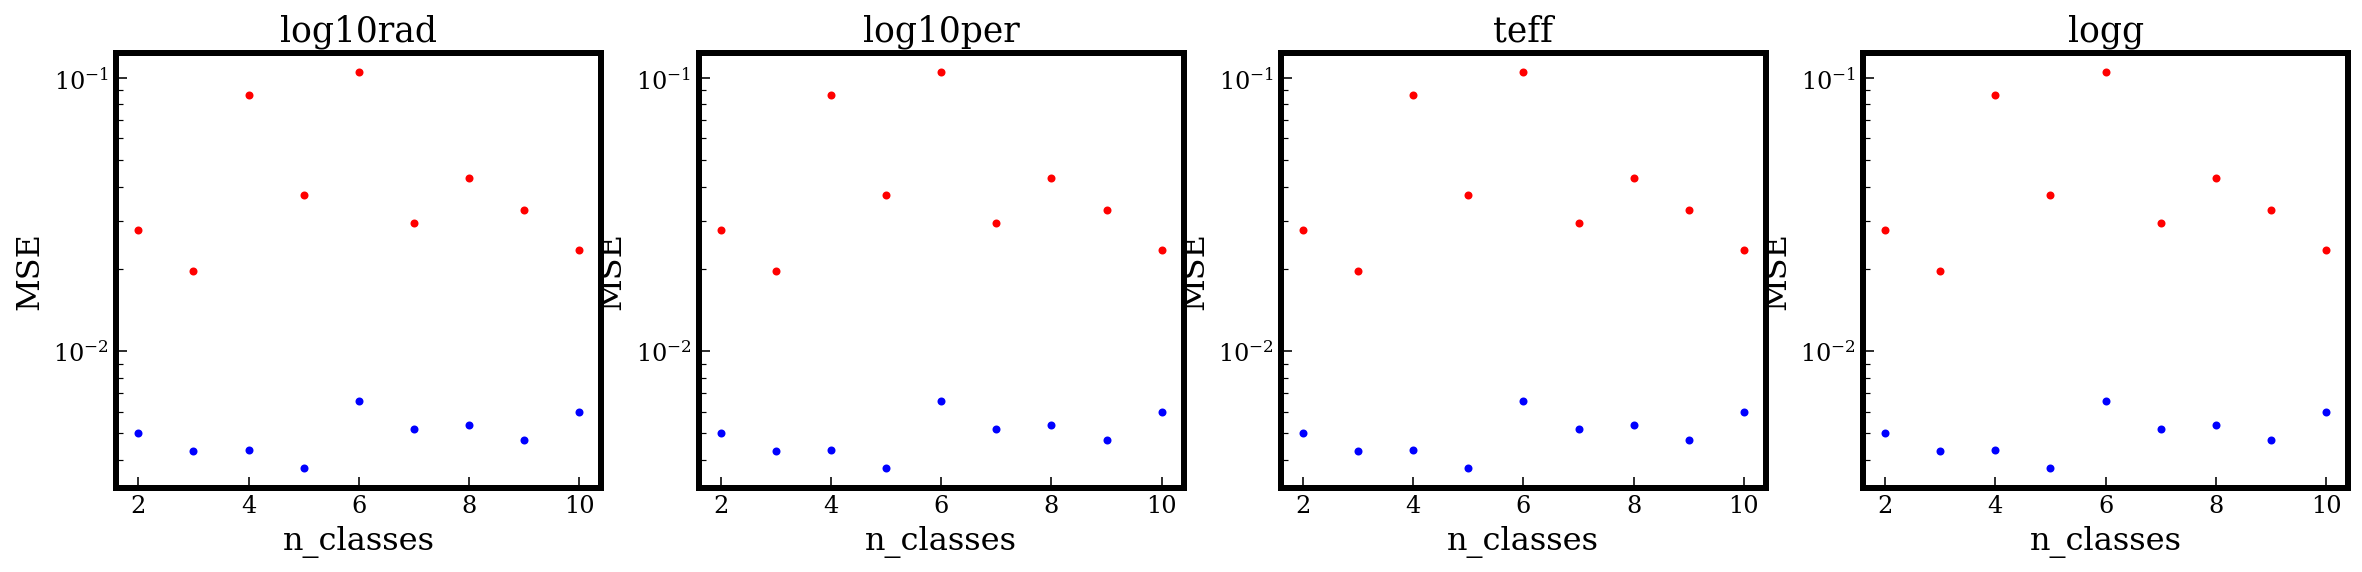

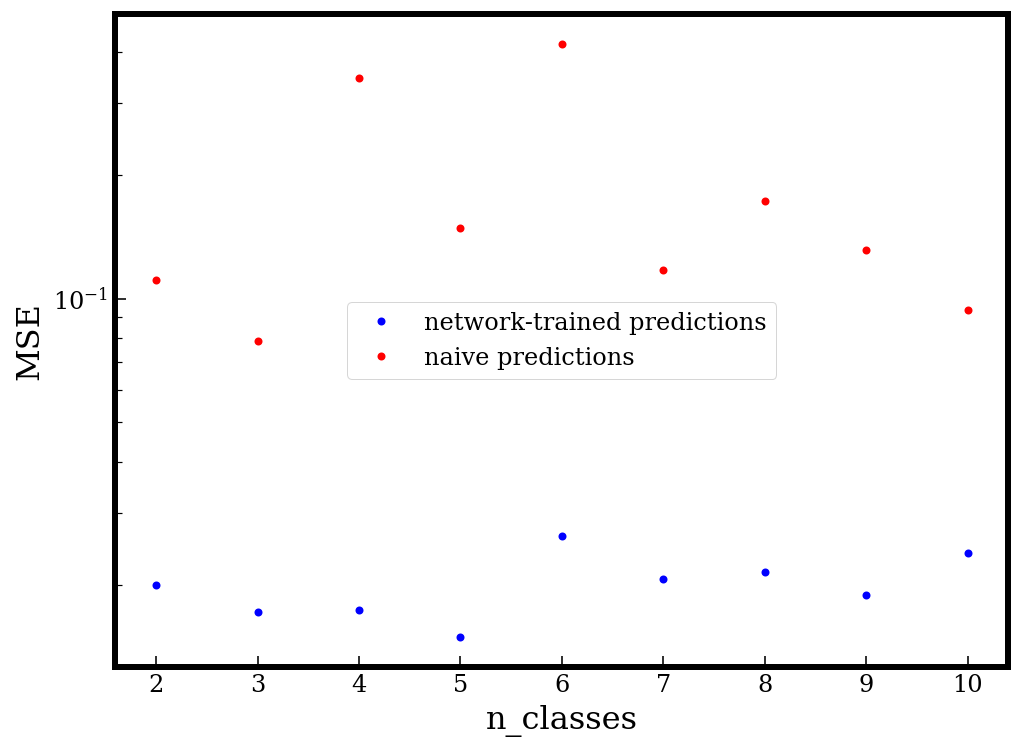

In [95]:
pred_arrs = [predMSE_rad,predMSE_per,predMSE_teff,predMSE_logg]
random_arrs = [randomMSE_rad,randomMSE_per,randomMSE_teff,randomMSE_logg]
labels = ["log10rad","log10per","teff","logg"]
fig,axes = plt.subplots(1,n_features,figsize=(5*n_features,4))
for j in range(n_features):
    axes[j].plot(classes,pred_arrs[j],'b.')
    axes[j].plot(classes,random_arrs[j],'r.')
    axes[j].set_xlabel("n_classes",fontsize=16)
    axes[j].set_ylabel("MSE",fontsize=16)
    axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(labels[j]))
plt.show()

pred_total = predMSE_rad + predMSE_per + predMSE_teff + predMSE_logg 
random_total = randomMSE_rad + randomMSE_per + randomMSE_teff + randomMSE_logg 

fig = plt.figure(figsize=(8,6))
plt.plot(classes,pred_total,'b.',label="network-trained predictions")
plt.plot(classes,random_total,'r.',label="naive predictions")
plt.xlabel("n_classes",fontsize=16)
plt.ylabel("MSE",fontsize=16)
plt.legend(loc="best")
plt.yscale("log")
plt.show()